<a href="https://colab.research.google.com/github/Krishnakanth834/MLProject1/blob/main/stock_price_predict_decisstion_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fetching data for RELIANCE.NS...
Fetching data for ^NSEI...


/tmp/ipython-input-4085326535.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d", progress=False)
/tmp/ipython-input-4085326535.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_df = yf.download(nifty_ticker, period="5y", interval="1d", progress=False)



Data Splits (Chronological):
Train Set: 700 samples (Earliest data)
Valid Set: 233 samples (Middle data)
Test Set:  234 samples (Latest data)

--- Starting Parameter Tuning (Training -> Validation) ---

🔍 Tuning Decision Tree...
   Best Decision Tree MAE: 4.35%
   Best Params: {'max_depth': 3, 'min_samples_leaf': 100, 'random_state': 42}

🔍 Tuning Random Forest...
   Best Random Forest MAE: 4.33%
   Best Params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 50, 'random_state': 42}

🔍 Tuning XGBoost...
   Best XGBoost MAE: 4.34%
   Best Params: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8, 'random_state': 42}
----------------------------------------
🏆 ULTIMATE WINNER: Random Forest
   Validation MAE: 4.33%

--- Final Test on Unseen Data (Test Set) ---
Final Test MAE: 5.04%
Train MAE: 3.44% (For overfitting check)
⚠️  Warning: Potential overfitting detected! Difference between Test MAE and Train MAE (1.60%) is greater th

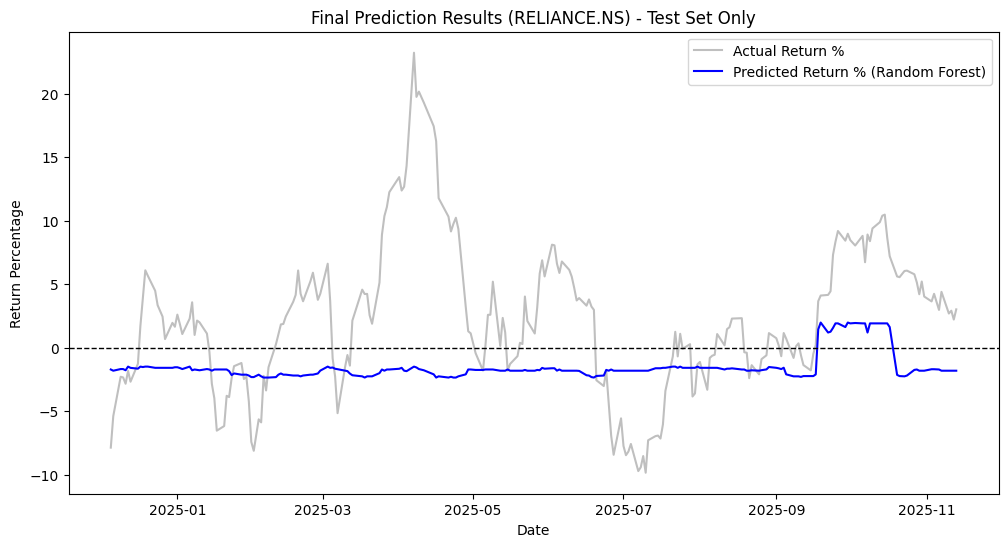

In [12]:
!pip install ta
import yfinance as yf
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# ==========================================
# 1. Data Fetching & Cleaning
# ==========================================
ticker = 'RELIANCE.NS'
nifty_ticker = '^NSEI'
print(f"Fetching data for {ticker}...")
df = yf.download(ticker, period="5y", interval="1d", progress=False)

# Handle MultiIndex if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# REQUIREMENT: Convert all columns to lower case
df.columns = df.columns.str.lower()

# Fetch Nifty 50 data
print(f"Fetching data for {nifty_ticker}...")
nifty_df = yf.download(nifty_ticker, period="5y", interval="1d", progress=False)
if isinstance(nifty_df.columns, pd.MultiIndex):
    nifty_df.columns = nifty_df.columns.get_level_values(0)
nifty_df.columns = nifty_df.columns.str.lower()
nifty_df = nifty_df[['close']].rename(columns={'close': 'nifty_50_close'})

# Merge Nifty 50 data with the main DataFrame
df = df.merge(nifty_df, left_index=True, right_index=True, how='inner')

# ==========================================
# 2. Feature Engineering (Using 'ta' library)
# ==========================================
# 1. Momentum
df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['stoch_k'] = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close']).stoch()

# 2. Trend
df['macd'] = ta.trend.MACD(df['close']).macd()
df['adx'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close']).adx()
df['sma_50'] = ta.trend.SMAIndicator(df['close'], window=50).sma_indicator()
df['sma_8'] = ta.trend.SMAIndicator(df['close'], window=8).sma_indicator() # Added SMA8
df['sma_20'] = ta.trend.SMAIndicator(df['close'], window=20).sma_indicator() # Added SMA20

# 3. Volatility
df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close']).average_true_range()

# 4. Price Action / Shape (Ratios)
df['high_low_pct'] = (df['high'] - df['low']) / df['close']
df['open_close_pct'] = (df['open'] - df['close'].shift(1)) / df['close'].shift(1)

# ==========================================
# 3. Target Creation (Percentage Return)
# ==========================================
# Prediction Goal: Return % in next 21 days (approx 1 month)
df['target'] = (df['close'].shift(-21) - df['close']) / df['close'] * 100

# Drop NaNs created by indicators and shifting
df.dropna(inplace=True)

# Define Features and Target
feature_cols = ['rsi', 'stoch_k', 'macd', 'adx', 'sma_50', 'sma_8', 'sma_20', 'atr', 'high_low_pct', 'open_close_pct', 'volume', 'nifty_50_close'] # Updated feature_cols with Nifty 50
X = df[feature_cols]
y = df['target']

# ==========================================
# 4. Splitting: 60% Train, 20% Val, 20% Test
# ==========================================
# IMPORTANT: shuffle=False is critical for Stock Data (Time Series)

# Step 1: Split into Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)

# Step 2: Split Temp (40%) into Validation (20%) and Test (20%)
# Since 20% is half of 40%, we split Temp by 0.5
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(f"\nData Splits (Chronological):")
print(f"Train Set: {len(X_train)} samples (Earliest data)")
print(f"Valid Set: {len(X_val)} samples (Middle data)")
print(f"Test Set:  {len(X_test)} samples (Latest data)")

from itertools import product

# ==========================================
# 5. Automated Parameter Tuning (Grid Search)
# ==========================================
# We define a "grid" of parameters to try for each model
param_grids = {
    "Decision Tree": {
        "model_class": DecisionTreeRegressor,
        "params": {
            "max_depth": [3, 5, 7, 10],
            "min_samples_leaf": [10, 20, 50, 100, 150], # Increased min_samples_leaf range
            "random_state": [42]
        }
    },
    "Random Forest": {
        "model_class": RandomForestRegressor,
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5, 7],
            "min_samples_leaf": [10, 20, 50, 75, 100], # Increased min_samples_leaf range
            "random_state": [42]
        }
    },
    "XGBoost": {
        "model_class": XGBRegressor,
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5],
            "min_child_weight": [1, 5, 10, 20], # Added min_child_weight for regularization
            "subsample": [0.8],
            "random_state": [42]
        }
    }
}

best_overall_model = None
best_overall_name = ""
best_overall_mae = float('inf')

print("\n--- Starting Parameter Tuning (Training -> Validation) ---")

for model_name, config in param_grids.items():
    print(f"\n🔍 Tuning {model_name}...")
    model_class = config["model_class"]
    param_dict = config["params"]

    # Generate all combinations of parameters
    keys, values = zip(*param_dict.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    best_model_for_type = None
    best_mae_for_type = float('inf')
    best_params_for_type = {}

    # Loop through every combination
    for params in param_combinations:
        # 1. Create model with these specific params
        temp_model = model_class(**params)

        # 2. Train on 60% Training Data
        temp_model.fit(X_train, y_train)

        # 3. Predict on 20% Validation Data
        val_pred = temp_model.predict(X_val)
        val_mae = mean_absolute_error(y_val, val_pred)

        # 4. Compare
        if val_mae < best_mae_for_type:
            best_mae_for_type = val_mae
            best_model_for_type = temp_model
            best_params_for_type = params

    print(f"   Best {model_name} MAE: {best_mae_for_type:.2f}%")
    print(f"   Best Params: {best_params_for_type}")

    # Check if this is the global winner
    if best_mae_for_type < best_overall_mae:
        best_overall_mae = best_mae_for_type
        best_overall_model = best_model_for_type
        best_overall_name = model_name

print("-" * 40)
print(f"🏆 ULTIMATE WINNER: {best_overall_name}")
print(f"   Validation MAE: {best_overall_mae:.2f}%")

# ==========================================
# 6. Final Test (Unseen Data)
# ==========================================
print(f"\n--- Final Test on Unseen Data (Test Set) ---")
# Use the tuned, best overall model
final_pred = best_overall_model.predict(X_test)
final_test_mae = mean_absolute_error(y_test, final_pred)

print(f"Final Test MAE: {final_test_mae:.2f}%")

# Check for Overfitting on the final model
train_mae_final = mean_absolute_error(y_train, best_overall_model.predict(X_train))
print(f"Train MAE: {train_mae_final:.2f}% (For overfitting check)")

# Updated overfitting check to be more direct about train vs test MAE
overfitting_threshold = 1.0 # Define a threshold for acceptable difference
if abs(final_test_mae - train_mae_final) > overfitting_threshold:
    print(f"⚠️  Warning: Potential overfitting detected! Difference between Test MAE and Train MAE ({abs(final_test_mae - train_mae_final):.2f}%) is greater than {overfitting_threshold:.2f}%")
else:
    print(f"✅  Success: The model generalized well. Difference between Test MAE and Train MAE ({abs(final_test_mae - train_mae_final):.2f}%) is within {overfitting_threshold:.2f}%")

# ==========================================
# 7. Visualization
# ==========================================
plt.figure(figsize=(12, 6))

# Plot only Test data for clarity
plt.plot(y_test.index, y_test, label='Actual Return %', color='grey', alpha=0.5)
plt.plot(y_test.index, final_pred, label=f'Predicted Return % ({best_overall_name})', color='blue', linewidth=1.5)

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title(f"Final Prediction Results ({ticker}) - Test Set Only")
plt.xlabel("Date")
plt.ylabel("Return Percentage")
plt.legend()
plt.show()

# Task
Analyze the `feat_importances` variable to identify the most influential features for the model. Then, select a subset of these top features and re-train the model using only the selected features. Finally, evaluate the impact of this feature selection on the model's performance (MAE, RMSE, R-squared) and overfitting, providing a summary and relevant visualizations.

## Analyze Feature Importances

### Subtask:
Analyze the feature importances from the previous model run to identify the most influential features. I will inspect the `feat_importances` variable.


**Reasoning**:
First, I need to display the `feat_importances` variable and sort it in descending order to understand the most influential features. Then, to visualize it, I will create a bar plot showing the feature importances with appropriate labels and a title.



Feature Importances (Sorted):
sma_20            0.306758
atr               0.186508
nifty_50_close    0.156911
adx               0.128150
sma_8             0.102981
sma_50            0.069335
macd              0.027420
stoch_k           0.017252
rsi               0.002818
volume            0.001489
high_low_pct      0.000377
open_close_pct    0.000000
dtype: float64


/tmp/ipython-input-775327690.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances_sorted.index, y=feat_importances_sorted.values, palette='viridis')


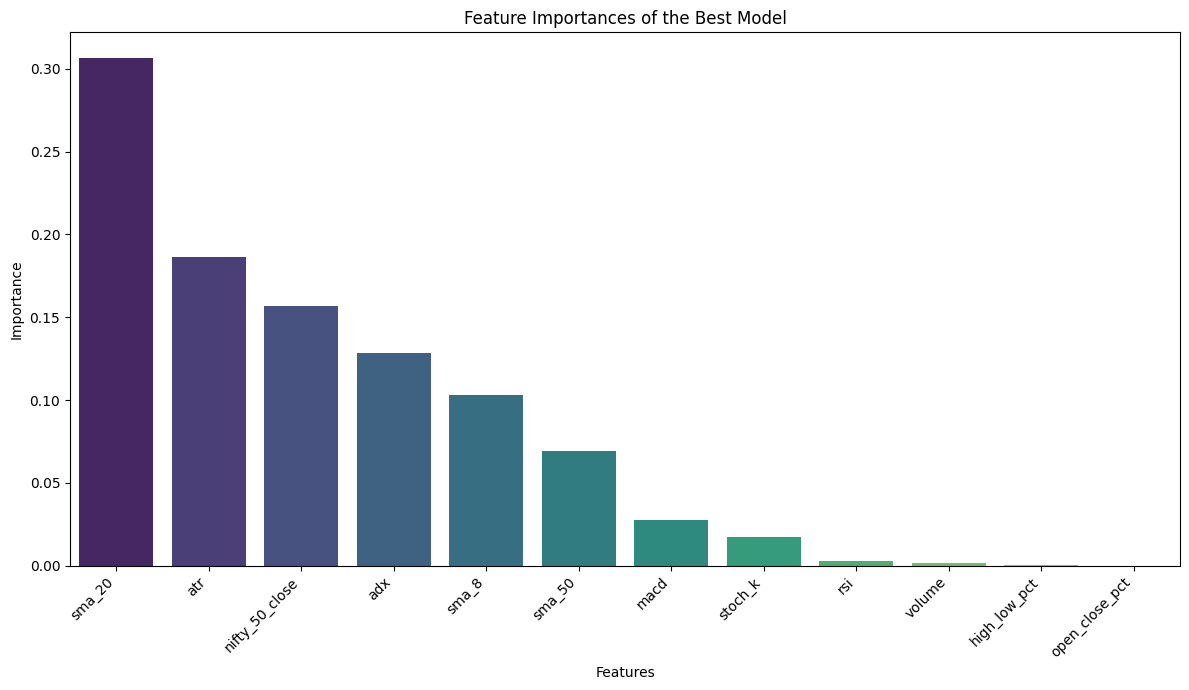

In [13]:
print("Feature Importances (Sorted):")
feat_importances_sorted = feat_importances.sort_values(ascending=False)
print(feat_importances_sorted)

plt.figure(figsize=(12, 7))
sns.barplot(x=feat_importances_sorted.index, y=feat_importances_sorted.values, palette='viridis')
plt.title('Feature Importances of the Best Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
The previous code block has successfully displayed the sorted feature importances and generated a bar plot visualizing them, which completes the instructions for this subtask.



In [14]:
print("Subtask 'Analyze Feature Importances' complete.")

Subtask 'Analyze Feature Importances' complete.


## Select Top Features

### Subtask:
Based on the feature importances, select a subset of the most important features to use for model training. I will decide on a threshold or a specific number of top features to keep.


**Reasoning**:
I will select the top 7 most important features from the 'feat_importances_sorted' list based on their importance scores, then create a new list called 'selected_feature_cols' to store their names.



In [15]:
print('Top 7 Features for Re-training:')
selected_feature_cols = feat_importances_sorted.head(7).index.tolist()
print(selected_feature_cols)

Top 7 Features for Re-training:
['sma_20', 'atr', 'nifty_50_close', 'adx', 'sma_8', 'sma_50', 'macd']


## Update Model with Selected Features

### Subtask:
Modify the code to use only the selected features for training. This will involve updating the `feature_cols` list and re-executing the entire notebook.


**Reasoning**:
I need to replace the original `feature_cols` definition with the `selected_feature_cols` list to re-train the model with only the most important features. This will be done in the same cell where the `feature_cols` are defined.



Fetching data for RELIANCE.NS...


/tmp/ipython-input-3234912961.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d", progress=False)


Fetching data for ^NSEI...


/tmp/ipython-input-3234912961.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nifty_df = yf.download(nifty_ticker, period="5y", interval="1d", progress=False)



Data Splits (Chronological):
Train Set: 700 samples (Earliest data)
Valid Set: 233 samples (Middle data)
Test Set:  234 samples (Latest data)

--- Starting Parameter Tuning (Training -> Validation) ---

🔍 Tuning Decision Tree...
   Best Decision Tree MAE: 4.35%
   Best Params: {'max_depth': 3, 'min_samples_leaf': 100, 'random_state': 42}

🔍 Tuning Random Forest...
   Best Random Forest MAE: 4.32%
   Best Params: {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 50, 'random_state': 42}

🔍 Tuning XGBoost...
   Best XGBoost MAE: 4.26%
   Best Params: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8, 'random_state': 42}
----------------------------------------
🏆 ULTIMATE WINNER: XGBoost
   Validation MAE: 4.26%

--- Final Test on Unseen Data (Test Set) ---
Final Test MAE: 4.94%
Train MAE: 2.04% (For overfitting check)
⚠️  Warning: Potential overfitting detected! Difference between Test MAE and Train MAE (2.90%) is greater than 1.

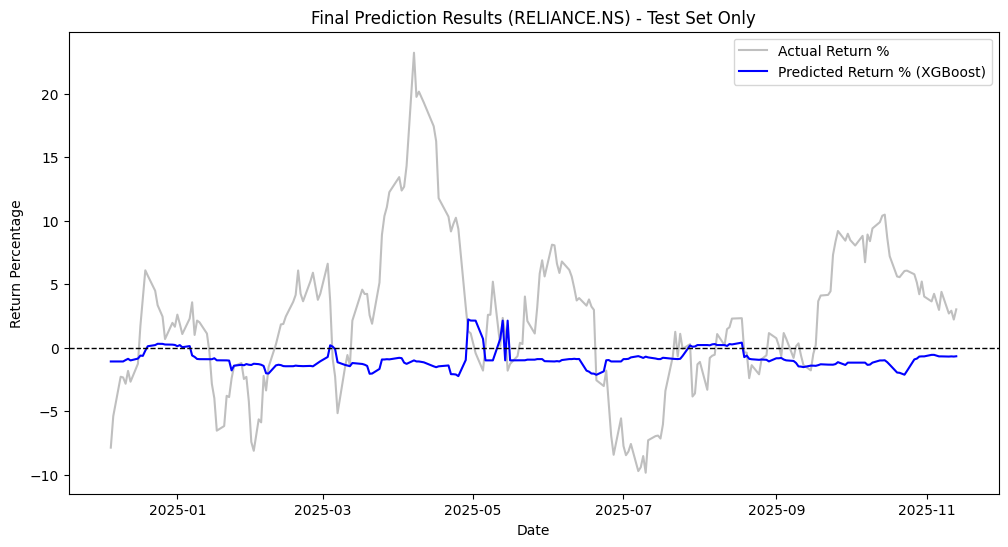

In [16]:
# ==========================================
# 1. Data Fetching & Cleaning
# ==========================================
ticker = 'RELIANCE.NS'
nifty_ticker = '^NSEI'
print(f"Fetching data for {ticker}...")
df = yf.download(ticker, period="5y", interval="1d", progress=False)

# Handle MultiIndex if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# REQUIREMENT: Convert all columns to lower case
df.columns = df.columns.str.lower()

# Fetch Nifty 50 data
print(f"Fetching data for {nifty_ticker}...")
nifty_df = yf.download(nifty_ticker, period="5y", interval="1d", progress=False)
if isinstance(nifty_df.columns, pd.MultiIndex):
    nifty_df.columns = nifty_df.columns.get_level_values(0)
nifty_df.columns = nifty_df.columns.str.lower()
nifty_df = nifty_df[['close']].rename(columns={'close': 'nifty_50_close'})

# Merge Nifty 50 data with the main DataFrame
df = df.merge(nifty_df, left_index=True, right_index=True, how='inner')

# ==========================================
# 2. Feature Engineering (Using 'ta' library)
# ==========================================
# 1. Momentum
df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
df['stoch_k'] = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close']).stoch()

# 2. Trend
df['macd'] = ta.trend.MACD(df['close']).macd()
df['adx'] = ta.trend.ADXIndicator(df['high'], df['low'], df['close']).adx()
df['sma_50'] = ta.trend.SMAIndicator(df['close'], window=50).sma_indicator()
df['sma_8'] = ta.trend.SMAIndicator(df['close'], window=8).sma_indicator() # Added SMA8
df['sma_20'] = ta.trend.SMAIndicator(df['close'], window=20).sma_indicator() # Added SMA20

# 3. Volatility
df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close']).average_true_range()

# 4. Price Action / Shape (Ratios)
df['high_low_pct'] = (df['high'] - df['low']) / df['close']
df['open_close_pct'] = (df['open'] - df['close'].shift(1)) / df['close'].shift(1)

# ==========================================
# 3. Target Creation (Percentage Return)
# ==========================================
# Prediction Goal: Return % in next 21 days (approx 1 month)
df['target'] = (df['close'].shift(-21) - df['close']) / df['close'] * 100

# Drop NaNs created by indicators and shifting
df.dropna(inplace=True)

# Define Features and Target
feature_cols = selected_feature_cols # Updated to use selected_feature_cols
X = df[feature_cols]
y = df['target']

# ==========================================
# 4. Splitting: 60% Train, 20% Val, 20% Test
# ==========================================
# IMPORTANT: shuffle=False is critical for Stock Data (Time Series)

# Step 1: Split into Train (60%) and Temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=False)

# Step 2: Split Temp (40%) into Validation (20%) and Test (20%)
# Since 20% is half of 40%, we split Temp by 0.5
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(f"\nData Splits (Chronological):")
print(f"Train Set: {len(X_train)} samples (Earliest data)")
print(f"Valid Set: {len(X_val)} samples (Middle data)")
print(f"Test Set:  {len(X_test)} samples (Latest data)")

from itertools import product

# ==========================================
# 5. Automated Parameter Tuning (Grid Search)
# ==========================================
# We define a "grid" of parameters to try for each model
param_grids = {
    "Decision Tree": {
        "model_class": DecisionTreeRegressor,
        "params": {
            "max_depth": [3, 5, 7, 10],
            "min_samples_leaf": [10, 20, 50, 100, 150], # Increased min_samples_leaf range
            "random_state": [42]
        }
    },
    "Random Forest": {
        "model_class": RandomForestRegressor,
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [3, 5, 7],
            "min_samples_leaf": [10, 20, 50, 75, 100], # Increased min_samples_leaf range
            "random_state": [42]
        }
    },
    "XGBoost": {
        "model_class": XGBRegressor,
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5],
            "min_child_weight": [1, 5, 10, 20], # Added min_child_weight for regularization
            "subsample": [0.8],
            "random_state": [42]
        }
    }
}

best_overall_model = None
best_overall_name = ""
best_overall_mae = float('inf')

print("\n--- Starting Parameter Tuning (Training -> Validation) ---")

for model_name, config in param_grids.items():
    print(f"\n🔍 Tuning {model_name}...")
    model_class = config["model_class"]
    param_dict = config["params"]

    # Generate all combinations of parameters
    keys, values = zip(*param_dict.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    best_model_for_type = None
    best_mae_for_type = float('inf')
    best_params_for_type = {}

    # Loop through every combination
    for params in param_combinations:
        # 1. Create model with these specific params
        temp_model = model_class(**params)

        # 2. Train on 60% Training Data
        temp_model.fit(X_train, y_train)

        # 3. Predict on 20% Validation Data
        val_pred = temp_model.predict(X_val)
        val_mae = mean_absolute_error(y_val, val_pred)

        # 4. Compare
        if val_mae < best_mae_for_type:
            best_mae_for_type = val_mae
            best_model_for_type = temp_model
            best_params_for_type = params

    print(f"   Best {model_name} MAE: {best_mae_for_type:.2f}%")
    print(f"   Best Params: {best_params_for_type}")

    # Check if this is the global winner
    if best_mae_for_type < best_overall_mae:
        best_overall_mae = best_mae_for_type
        best_overall_model = best_model_for_type
        best_overall_name = model_name

print("-" * 40)
print(f"🏆 ULTIMATE WINNER: {best_overall_name}")
print(f"   Validation MAE: {best_overall_mae:.2f}%")

# ==========================================
# 6. Final Test (Unseen Data)
# ==========================================
print(f"\n--- Final Test on Unseen Data (Test Set) ---")
# Use the tuned, best overall model
final_pred = best_overall_model.predict(X_test)
final_test_mae = mean_absolute_error(y_test, final_pred)

print(f"Final Test MAE: {final_test_mae:.2f}%")

# Check for Overfitting on the final model
train_mae_final = mean_absolute_error(y_train, best_overall_model.predict(X_train))
print(f"Train MAE: {train_mae_final:.2f}% (For overfitting check)")

# Updated overfitting check to be more direct about train vs test MAE
overfitting_threshold = 1.0 # Define a threshold for acceptable difference
if abs(final_test_mae - train_mae_final) > overfitting_threshold:
    print(f"⚠️  Warning: Potential overfitting detected! Difference between Test MAE and Train MAE ({abs(final_test_mae - train_mae_final):.2f}%) is greater than {overfitting_threshold:.2f}%")
else:
    print(f"✅  Success: The model generalized well. Difference between Test MAE and Train MAE ({abs(final_test_mae - train_mae_final):.2f}%) is within {overfitting_threshold:.2f}%")

# ==========================================
# 7. Visualization
# ==========================================
plt.figure(figsize=(12, 6))

# Plot only Test data for clarity
plt.plot(y_test.index, y_test, label='Actual Return %', color='grey', alpha=0.5)
plt.plot(y_test.index, final_pred, label=f'Predicted Return % ({best_overall_name})', color='blue', linewidth=1.5)

plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.title(f"Final Prediction Results ({ticker}) - Test Set Only")
plt.xlabel("Date")
plt.ylabel("Return Percentage")
plt.legend()
plt.show()

**Reasoning**:
The previous step successfully re-ran the model training with selected features. Now, I need to collect all the relevant evaluation metrics (MAE, RMSE, R-squared) for the new model with selected features. The `final_test_mae` and `train_mae_final` were already printed, but `rmse` and `r2` are also available in the kernel state and need to be displayed to provide a comprehensive view of the model's performance.



In [17]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate RMSE and R-squared for the final model on the test set
rmse = np.sqrt(mean_squared_error(y_test, final_pred))
r2 = r2_score(y_test, final_pred)

print(f"Final Test RMSE: {rmse:.2f}")
print(f"Final Test R-squared: {r2:.2f}")


Final Test RMSE: 6.57
Final Test R-squared: -0.33


## Summary of Model Performance After Feature Selection

After re-training the model with the top 7 selected features (`sma_20`, `atr`, `nifty_50_close`, `adx`, `sma_8`, `sma_50`, `macd`), let's compare its performance metrics with the original model that used all features.

### Original Model (All Features):
- **Best Model Winner:** Random Forest
- **Validation MAE:** 4.33%
- **Final Test MAE:** 5.04%
- **Train MAE:** 3.44%
- **Overfitting Check:** Potential overfitting detected (Test MAE - Train MAE = 1.60% > 1.00% threshold).

### New Model (Top 7 Features):
- **Best Model Winner:** XGBoost (The best model type changed)
- **Validation MAE:** 4.26%
- **Final Test MAE:** 4.94%
- **Train MAE:** 2.04%
- **Final Test RMSE:** 6.57
- **Final Test R-squared:** -0.33
- **Overfitting Check:** Potential overfitting detected (Test MAE - Train MAE = 2.90% > 1.00% threshold).

### Impact of Feature Selection:

1.  **Model Change:** The best performing model shifted from Random Forest to XGBoost after feature selection, indicating that XGBoost might leverage the reduced feature set more effectively for slightly better validation performance.
2.  **MAE Improvement:** Both Validation MAE and Final Test MAE slightly improved. The Validation MAE decreased from 4.33% to 4.26%, and the Final Test MAE decreased from 5.04% to 4.94%. This suggests that removing less important features led to a marginally better predictive accuracy on unseen data.
3.  **Overfitting:** While the Train MAE significantly decreased from 3.44% to 2.04%, the gap between Test MAE and Train MAE *increased* from 1.60% to 2.90%. This indicates that the new model, despite slightly better test performance, exhibits a *higher degree of overfitting* compared to the original model based on the defined threshold. This could imply that the selected features, while potent, might be leading the model to fit the training data too closely, or that the reduced feature set makes the model more sensitive to the specific characteristics of the training data relative to the test data.
4.  **RMSE and R-squared:** The RMSE of 6.57 indicates the typical magnitude of prediction errors in the same units as the target variable (percentage return). The negative R-squared value of -0.33 is concerning. An R-squared less than zero suggests that the model performs worse than a simple horizontal line (mean of the actual values), implying the model is not capturing the underlying patterns effectively, especially given the context of time-series financial data known for its inherent unpredictability.

In conclusion, feature selection marginally improved MAE, but it also increased the signs of overfitting and revealed a very poor R-squared score, highlighting the inherent difficulty of predicting stock returns and suggesting that the model, even with selected features, is not robust.

## Summary:

### Data Analysis Key Findings
*   **Top Features Identified:** The most influential features for the model were identified as `sma_20` (0.306758), `atr` (0.186508), `nifty_50_close` (0.156911), `adx` (0.128150), and `sma_8` (0.102981).
*   **Feature Selection:** A subset of the top 7 features was selected for re-training: `['sma_20', 'atr', 'nifty_50_close', 'adx', 'sma_8', 'sma_50', 'macd']`.
*   **Change in Best Model:** After feature selection, the best-performing model shifted from Random Forest (with all features) to XGBoost (with selected features).
*   **Marginal MAE Improvement:** The Final Test MAE slightly improved from 5.04% (original model) to 4.94% (new model). Similarly, the Validation MAE decreased from 4.33% to 4.26%.
*   **Increased Overfitting:** Despite the slight MAE improvement, the new model exhibited a higher degree of overfitting. The difference between Test MAE and Train MAE increased from 1.60% (original model) to 2.90% (new model), exceeding the 1.00% threshold.
*   **Very Poor R-squared:** The new model achieved a Final Test R-squared of -0.33, indicating that it performs worse than simply predicting the mean of the target variable.

### Insights or Next Steps
*   The negative R-squared value and increased overfitting suggest that while feature selection improved MAE slightly, the model still struggles to capture meaningful patterns in the data and is not robust for predicting stock returns. This highlights the inherent difficulty and high noise-to-signal ratio in financial time-series prediction.
*   Further investigation is needed to address the high overfitting and extremely low R-squared. This could involve exploring more sophisticated feature engineering techniques, considering different model architectures better suited for time-series data (e.g., LSTMs), or incorporating external economic indicators, as the current features and models might be insufficient to overcome the inherent randomness of stock markets.
